In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
import sys
import os

sys.path.insert(0, os.path.abspath("../.."))
sys.path.append(os.path.abspath("../../backend"))
sys.path.append(os.path.abspath(""))

from sqlalchemy.orm import aliased, joinedload, selectinload, contains_eager
from sqlalchemy import text
from rdflib.plugins.stores.sparqlstore import SPARQLStore
from backend.model import (
    DeclarativeBase,
    Session,
)

from backend.ontology import OntologyManager, OntologyConfig, Graph
from backend.explorative_support import TopicModelling, select
from backend.llm_query import (
    Entity,
    Relation,
    EntitiesRelations,
    EnrichedEntity,
    EnrichedRelation,
    EnrichedEntitiesRelations,
    SubjectLink,
    SubjectInDB,
    SubjectLinkDB,
)
from tqdm import tqdm
import pandas as pd

from eval_config import DBPEDIA_CONFIGS, OMA_CONFIGS, SelectionDistribution, EvalConfig

# db_setups = [DBPEDIA_CONFIGS[1], OMA_CONFIGS[1]]
db_setups = [OMA_CONFIGS[0]]
setup=db_setups[0]
print("Generating for ", setup.name)
store = SPARQLStore(
    setup.sparql_endpoint,
    method="POST_FORM",
    params={"infer": False, "sameAs": False},
)
graph = Graph(store=store)

config = OntologyConfig()

ontology_manager = OntologyManager(config, graph)
topic_man = TopicModelling(
    ontology_manager,
    llm_model_id=setup.model_id,
    conn_str=setup.conn_str,
)
llama_model = topic_man.llama_model

Generating for  OMA
Loading LLM model NousResearch/Hermes-3-Llama-3.1-8B-GGUF None


ggml_cuda_init: GGML_CUDA_FORCE_MMQ:    yes
ggml_cuda_init: GGML_CUDA_FORCE_CUBLAS: no
ggml_cuda_init: found 1 CUDA devices:
  Device 0: NVIDIA GeForce RTX 4090, compute capability 8.9, VMM: yes
llama_load_model_from_file: using device CUDA0 (NVIDIA GeForce RTX 4090) - 23587 MiB free
llama_model_loader: loaded meta data with 27 key-value pairs and 292 tensors from /home/bkantz/.cache/huggingface/hub/models--NousResearch--Hermes-3-Llama-3.1-8B-GGUF/snapshots/307a5dfb59aa38d88b6cfd32f44b8ad7c1da9fb8/./Hermes-3-Llama-3.1-8B.Q8_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Hermes 3 Llama 3.1 8B
llama_model_loader: - kv   3

In [4]:
top_k = 100
seed = 42

In [26]:
from typing import TypeVar

SL = TypeVar("SL")


class EnrichedDBEntity(Entity, arbitrary_types_allowed=True):
    subject: SubjectInDB


class EnrichedDBRelation(Relation, arbitrary_types_allowed=True):
    link: SubjectLinkDB


def safe_prob(probs: np.array):
    if np.sum(probs) == 0:
        return np.ones(len(probs)) / len(probs)
    else:
        return probs / probs.sum()


def choose_entity(
    links: list[SL],
    rs: np.random.RandomState,
    dist: SelectionDistribution = SelectionDistribution.INSTANCES,
) -> SL:
    probs = np.array([link.instance_count for link in links])
    probs = (
        safe_prob(probs)
        if dist == SelectionDistribution.INSTANCES
        else np.ones(len(probs)) / len(probs)
    )
    indices = np.arange(len(links))
    choice = rs.choice(indices, p=probs)
    return links[choice]


def random_downgrade(
    cls: SubjectInDB,
    rs: np.random.RandomState,
    dist: SelectionDistribution = SelectionDistribution.INSTANCES,
) -> SubjectInDB:
    def get_subclasses(subcls: SubjectInDB):
        subclasses = [subcls.sub_classes] + [
            get_subclasses(sub) for sub in subcls.sub_classes
        ]
        return [sub for sublist in subclasses for sub in sublist]

    # print(f"downgrading {cls.label}", [sc.label for sc in cls.sub_classes])
    subclasses = [cls] + get_subclasses(cls)
    probs = np.array([float(sc.instance_count) for sc in subclasses])
    probs = (
        safe_prob(probs)
        if dist == SelectionDistribution.INSTANCES
        else np.ones(len(probs)) / len(probs)
    )
    # print(f"{cls.label} probs", probs)
    choice = rs.choice(np.arange(len(subclasses)), p=probs)
    return subclasses[choice]


def choose_graph(
    max_nodes=4,
    top_k=top_k,
    seed=seed,
    max_tries=5,
    topic_man: TopicModelling = None,
    cfg: EvalConfig = DBPEDIA_CONFIGS[0],
):
    rs = np.random.RandomState(seed)
    with Session(topic_man.engine) as session:
        session.execute(text("SET TRANSACTION READ ONLY"))
        session.autoflush = False

        def downgrade_link_subjects(link: SubjectLinkDB):
            from_downgrade = random_downgrade(
                link.from_subject, rs, cfg.selection_distribution
            )
            to_downgrade = random_downgrade(
                link.to_subject, rs, cfg.selection_distribution
            )
            link.from_id = from_downgrade.subject_id
            link.to_id = to_downgrade.subject_id
            link.from_subject = from_downgrade
            link.to_subject = to_downgrade
            return link

        from_subject_alias = aliased(SubjectInDB, name="from_subject")
        to_subject_alias = aliased(SubjectInDB, name="to_subject")
        best_links_db = session.execute(
            select(SubjectLinkDB)
            .filter(SubjectLinkDB.from_id != SubjectLinkDB.to_id)
            # .filter(SubjectLinkDB.to_id != None)
            .order_by(SubjectLinkDB.instance_count.desc())
            .join(
                from_subject_alias,
                SubjectLinkDB.from_subject.of_type(from_subject_alias),
            )
            .join(to_subject_alias, SubjectLinkDB.to_subject.of_type(to_subject_alias))
            # .options(
            #     lazyload(SubjectLinkDB.from_subject.of_type(from_subject_alias)),
            #     lazyload(SubjectLinkDB.to_subject.of_type(to_subject_alias)),
            # )
            .limit(top_k)
        ).all()
        best_links: list[SubjectLinkDB] = [link[0] for link in best_links_db]
        choice = choose_entity(best_links, rs, cfg.selection_distribution)
        choice_downgraded = downgrade_link_subjects(choice)

        current_links = [
            (
                EnrichedDBRelation(
                    entity=choice_downgraded.from_subject.label,
                    relation=choice.label,
                    target=choice_downgraded.to_subject.label,
                    link=choice_downgraded,
                )
            )
        ]
        current_nodes = {
            subject.label: EnrichedDBEntity(
                identifier=subject.label,
                type=subject.label,
                subject=subject,
            )
            for subject in [
                choice_downgraded.from_subject,
                choice_downgraded.to_subject,
            ]
        }
        retries = 0
        while len(current_nodes) < max_nodes:
            start_node = choose_entity(
                list([nd.subject for nd in current_nodes.values()]),
                rs,
                cfg.selection_distribution,
            )
            left_right = rs.choice([0, 1])
            extending_to = left_right == 0
            query = (
                select(SubjectLinkDB)
                .where(SubjectLinkDB.from_id != SubjectLinkDB.to_id)
                .where(SubjectLinkDB.to_id is not None)
                .join(
                    from_subject_alias,
                    SubjectLinkDB.from_subject.of_type(from_subject_alias),
                )
                .join(
                    to_subject_alias, SubjectLinkDB.to_subject.of_type(to_subject_alias)
                )
                .filter(
                    SubjectLinkDB.link_id.not_in(
                        [link.link.link_id for link in current_links]
                    )
                )
            )
            if extending_to:
                query = query.where(SubjectLinkDB.from_id == start_node.subject_id)
            else:
                query = query.where(SubjectLinkDB.to_id == start_node.subject_id)
            # print("Extending to", start_node.label, "extending_to", extending_to)
            new_links = session.execute(
                query.order_by(SubjectLinkDB.instance_count.desc()).limit(top_k)
            ).all()
            new_links: list[SubjectLinkDB] = [link[0] for link in new_links]
            if len(new_links) == 0:
                if retries >= max_tries:
                    break
                retries += 1
                continue
            choice = choose_entity(new_links, rs, cfg.selection_distribution)

            extending_direction = (
                (choice.from_subject, choice.to_subject)
                if extending_to
                else (choice.to_subject, choice.from_subject)
            )

            downgraded_extend = random_downgrade(
                extending_direction[1], rs, cfg.selection_distribution
            )
            # print(
            #     "Downgraded from",
            #     extending_direction[1].label,
            #     downgraded_extend.label,
            #     "on link",
            #     choice.label,
            # )
            if extending_to:
                choice.to_id = downgraded_extend.subject_id
                choice.to_subject = downgraded_extend
            else:
                choice.from_id = downgraded_extend.subject_id
                choice.from_subject = downgraded_extend
            current_links.append(
                EnrichedDBRelation(
                    entity=choice.from_subject.label,
                    relation=choice.label,
                    target=choice.to_subject.label,
                    link=choice,
                )
            )
            current_nodes.update(
                {
                    subject.label: EnrichedDBEntity(
                        identifier=subject.label,
                        type=subject.label,
                        subject=subject,
                    )
                    for subject in [extending_direction[0], downgraded_extend]
                }
            )
        enriched_erl = EnrichedEntitiesRelations(
            entities=[
                EnrichedEntity(
                    subject=topic_man.oman.enrich_subject(entity.subject.subject_id),
                    **entity.model_dump(exclude=["subject"]),
                )
                for entity in current_nodes.values()
            ],
            relations=[
                EnrichedRelation(
                    link=SubjectLink.from_db(relation.link, topic_man.oman),
                    **relation.model_dump(exclude=["link"]),
                )
                for relation in current_links
            ],
        )
        return enriched_erl


erl = choose_graph(seed=304, max_nodes=10, topic_man=topic_man, cfg=setup)

In [25]:
[(link.entity, link.relation, link.target) for link in erl.relations]

[('co-orthology relation', 'has co-orthologous member', 'gene region'),
 ('co-orthology relation', 'has inparalogous member', 'inparalogy relation')]

In [8]:
erl.entities[0].model_dump_json()

'{"identifier":"Hierarchical clustering tree","type":"Hierarchical clustering tree","constraints":[],"subject":{"subject_id":"<http://purl.org/net/orth#HierarchicalClusteringTree>","label":"Hierarchical clustering tree","spos":{"rdfs:label":{"property":"rdfs:label","label":null,"values":[{"value":"Hierarchical clustering tree","label":null}]},"rdfs:subClassOf":{"property":"rdfs:subClassOf","label":null,"values":[{"value":"<http://purl.obolibrary.org/obo/CDAO_0000012>","label":"RootedTree"}]}},"subject_type":"class","refcount":0,"descendants":{},"total_descendants":0,"properties":{},"instance_count":0}}'

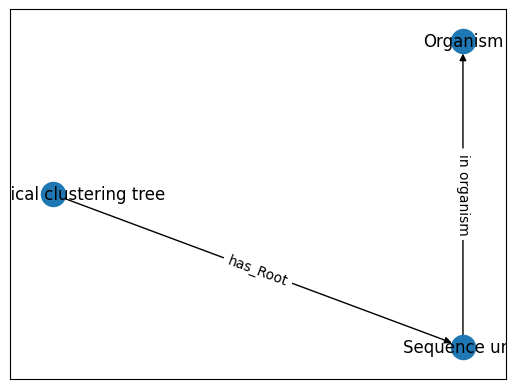

In [9]:
import networkx as nx


def viz_graph(erl: EnrichedEntitiesRelations):
    G = nx.DiGraph()
    for node in erl.entities:
        G.add_node(node.identifier, label=node.type)
    for link in erl.relations:
        G.add_edge(
            link.entity, link.target, weight=link.link.instance_count, label=link.relation
        )
    pos = nx.shell_layout(G)
    nx.draw_networkx(
        G,
        pos,
        with_labels=True,
        labels={node.identifier: node.type for node in erl.entities},
    )
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels={(link.entity, link.target): link.relation for link in erl.relations}
    )
    return G


viz_graph(erl)

In [16]:
def erl_to_templated_query(erl: EnrichedEntitiesRelations):
    qs= []
    for rel in erl.relations:
        qs.append(f"a {rel.entity} has a {rel.relation} with {rel.target}")
    return ", and ".join(qs)
print(erl_to_templated_query(erl))

a person has a birth place with populated place, and a person has a alma mater with school, and a radio station has a broadcast area with populated place, and a populated place has a leader name with athlete, and a person has a military service with military service, and a album has a auteur with person, and a river has a mouth place with populated place, and a person has a career station with career station, and a Sports team member has a career station with career station


In [17]:
def reduce_erl(erl: EnrichedEntitiesRelations):
    reduced_erl = EntitiesRelations(entities=erl.entities, relations=erl.relations)
    return reduced_erl
reduce_erl(erl).model_dump_json()

'{"relations":[{"entity":"person","relation":"birth place","target":"populated place"},{"entity":"person","relation":"alma mater","target":"school"},{"entity":"radio station","relation":"broadcast area","target":"populated place"},{"entity":"populated place","relation":"leader name","target":"athlete"},{"entity":"person","relation":"military service","target":"military service"},{"entity":"album","relation":"auteur","target":"person"},{"entity":"river","relation":"mouth place","target":"populated place"},{"entity":"person","relation":"career station","target":"career station"},{"entity":"Sports team member","relation":"career station","target":"career station"}],"entities":[{"identifier":"person","type":"person","constraints":[]},{"identifier":"populated place","type":"populated place","constraints":[]},{"identifier":"school","type":"school","constraints":[]},{"identifier":"radio station","type":"radio station","constraints":[]},{"identifier":"athlete","type":"athlete","constraints":[]

In [11]:
llama_model = topic_man.llama_model

ggml_cuda_init: GGML_CUDA_FORCE_MMQ:    yes
ggml_cuda_init: GGML_CUDA_FORCE_CUBLAS: no
ggml_cuda_init: found 1 CUDA devices:
  Device 0: NVIDIA GeForce RTX 4090, compute capability 8.9, VMM: yes
llama_load_model_from_file: using device CUDA0 (NVIDIA GeForce RTX 4090) - 23307 MiB free
llama_model_loader: loaded meta data with 27 key-value pairs and 292 tensors from /home/bkantz/.cache/huggingface/hub/models--NousResearch--Hermes-3-Llama-3.1-8B-GGUF/snapshots/307a5dfb59aa38d88b6cfd32f44b8ad7c1da9fb8/./Hermes-3-Llama-3.1-8B.Q8_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Hermes 3 Llama 3.1 8B
llama_model_loader: - kv   3

In [12]:
messages = [
    {
        "role": "system",
        "content": """"You are a helpful assistant turning relational knowledge into natural language.""",
    },
    {
        "role": "user",
        "content": EntitiesRelations(
            entities=[
                Entity(
                    identifier="person 1",
                    type="person",
                ),
                Entity(
                    identifier="place 1",
                    type="place",
                ),
                Entity(
                    identifier="company 1",
                    type="person",
                ),
            ],
            relations=[
                Relation(
                    entity="company 1",
                    relation="employs",
                    target="person 1",
                ),
                Relation(
                    entity="person 1",
                    relation="residence",
                    target="place 1",
                ),
            ],
        ).model_dump_json(),
    },
    {
        "role": "assistant",
        "content": "a person is employed by a company and the same person resides in a place",
    },
]


In [13]:
response = llama_model.create_chat_completion(
    # grammar=self.grammar_erl,
    messages=messages + [
        {
            "role": "user",
            "content": erl.model_dump_json(),
        }
    ],
    max_tokens=-1,
    temperature=0.7,  # get wild :)
)


llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  4906 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    80 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    2105.09 ms /  4986 tokens


In [14]:
response["choices"][0]["message"]["content"]

'a person is born in a populated place, attends a school, is employed by a radio station, is led by an athlete, serves in military service, creates an album, ends in a river, is in a career station, is a sports team member, and is related to a career station. Additionally, a populated place has a leader named an athlete, and a river has a mouth place.'

In [ ]:
n_examples = 300
n_nodes = [3, 5, 10]
resulting_examples = []
progress = tqdm(total=n_examples * len(n_nodes))
for n_node in n_nodes:
    for i in range(n_examples):
        
        erl = choose_graph(seed=i, max_nodes=n_node)
        response = llama_model.create_chat_completion(
            # grammar=self.grammar_erl,
            messages=messages
            + [
                {
                    "role": "user",
                    "content": erl.model_dump_json(),
                }
            ],
            max_tokens=-1,
            temperature=0.7,  # get wild :)
        )
        progress.update(1)
        resulting_examples.append(
            {
                "erl": erl.model_dump_json(),
                "response": response["choices"][0]["message"]["content"],
                "n_nodes": n_node,
                "seed": i,
            }
        )
        topic_man.engine.dispose()
        
resulting_examples_df = pd.DataFrame(resulting_examples)
resulting_examples_df.to_csv("llama_examples.csv")

  0%|          | 0/900 [00:00<?, ?it/s]

Extending to Organisation member extending_to False
Downgraded from organisation company on link organisation member


Llama.generate: 139 prefix-match hit, remaining 1143 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1143 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    46 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     700.79 ms /  1189 tokens
  0%|          | 1/900 [00:01<21:35,  1.44s/it]

Extending to written work extending_to False
Downgraded from multi volume publication multi volume publication on link volumes


Llama.generate: 139 prefix-match hit, remaining 1152 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1152 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    18 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     361.06 ms /  1170 tokens
  0%|          | 2/900 [00:02<16:02,  1.07s/it]

Extending to work extending_to True
Downgraded from person person on link auteur


Llama.generate: 139 prefix-match hit, remaining 1090 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1090 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    15 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     327.57 ms /  1105 tokens
  0%|          | 3/900 [00:03<14:50,  1.01it/s]

Extending to Organisation member extending_to False
Downgraded from organisation organisation on link organisation member


Llama.generate: 139 prefix-match hit, remaining 1212 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1212 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    13 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     296.53 ms /  1225 tokens
  0%|          | 4/900 [00:04<14:37,  1.02it/s]

Extending to Sports team member extending_to True
Extending to Sports team member extending_to True
Extending to Sports team member extending_to True
Extending to Sports team member extending_to False
Extending to Sports team member extending_to True
Extending to Sports team member extending_to True


Llama.generate: 139 prefix-match hit, remaining 677 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   677 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    13 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     267.01 ms /   690 tokens
  1%|          | 5/900 [00:04<13:39,  1.09it/s]

Extending to place extending_to True
Downgraded from person function person function on link political leader


Llama.generate: 139 prefix-match hit, remaining 1120 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1120 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    16 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     330.86 ms /  1136 tokens
  1%|          | 6/900 [00:05<14:21,  1.04it/s]

Extending to route of transportation extending_to True
Downgraded from station station on link route end
Extending to station extending_to True
Extending to route of transportation extending_to True
Downgraded from station station on link route end
Extending to route of transportation extending_to True
Downgraded from station station on link route junction
Extending to station extending_to False
Downgraded from route of transportation road on link route junction


Llama.generate: 139 prefix-match hit, remaining 2207 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  2207 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    29 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     635.65 ms /  2236 tokens
  1%|          | 7/900 [00:07<15:56,  1.07s/it]

Extending to career station extending_to True
Extending to career station extending_to False
Extending to career station extending_to True
Extending to career station extending_to True
Extending to career station extending_to True
Extending to career station extending_to False


Llama.generate: 139 prefix-match hit, remaining 673 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   673 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    34 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     507.59 ms /   707 tokens
  1%|          | 8/900 [00:08<15:16,  1.03s/it]

Extending to politician extending_to True
Downgraded from person Organisation member on link prefect


Llama.generate: 139 prefix-match hit, remaining 1171 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1171 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    27 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     477.42 ms /  1198 tokens
  1%|          | 9/900 [00:09<15:19,  1.03s/it]

Extending to athlete extending_to False
Downgraded from sports event soccer tournoment on link champion in double male


Llama.generate: 139 prefix-match hit, remaining 1198 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1198 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    19 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     382.96 ms /  1217 tokens
  1%|          | 10/900 [00:10<14:55,  1.01s/it]

Extending to work extending_to False
Downgraded from television show television show on link opening theme


Llama.generate: 139 prefix-match hit, remaining 1287 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1287 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    46 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     722.68 ms /  1333 tokens
  1%|          | 11/900 [00:11<15:44,  1.06s/it]

Extending to career station extending_to False
Extending to person extending_to True
Downgraded from educational institution school on link alma mater


Llama.generate: 139 prefix-match hit, remaining 1149 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1149 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    25 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     447.80 ms /  1174 tokens
  1%|▏         | 12/900 [00:12<16:31,  1.12s/it]

Extending to career station extending_to True
Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to True
Extending to career station extending_to True


Llama.generate: 139 prefix-match hit, remaining 758 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   758 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    12 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     241.29 ms /   770 tokens
  1%|▏         | 13/900 [00:13<14:15,  1.04it/s]

Extending to work extending_to True
Downgraded from agent sports club on link producer


Llama.generate: 139 prefix-match hit, remaining 1106 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1106 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    15 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     312.67 ms /  1121 tokens
  2%|▏         | 14/900 [00:14<13:37,  1.08it/s]

Extending to cricket team extending_to True
Extending to winter sport Player extending_to False
Extending to winter sport Player extending_to True
Extending to winter sport Player extending_to True
Extending to winter sport Player extending_to False
Extending to winter sport Player extending_to True


Llama.generate: 139 prefix-match hit, remaining 678 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   678 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    14 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     257.83 ms /   692 tokens
  2%|▏         | 15/900 [00:14<13:02,  1.13it/s]

Extending to person extending_to False
Downgraded from athlete athlete on link trainer


Llama.generate: 139 prefix-match hit, remaining 1136 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1136 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    39 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     622.85 ms /  1175 tokens
  2%|▏         | 16/900 [00:16<14:36,  1.01it/s]

Extending to person extending_to False
Downgraded from work work on link author


Llama.generate: 143 prefix-match hit, remaining 1099 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1099 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    37 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     592.24 ms /  1136 tokens
  2%|▏         | 17/900 [00:17<16:01,  1.09s/it]

Extending to person extending_to True
Downgraded from career station career station on link career station


Llama.generate: 148 prefix-match hit, remaining 1129 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1129 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    13 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     296.09 ms /  1142 tokens
  2%|▏         | 18/900 [00:18<15:18,  1.04s/it]

Extending to musical work extending_to True
Downgraded from agent agent on link performer


Llama.generate: 139 prefix-match hit, remaining 1140 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1140 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    28 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     482.32 ms /  1168 tokens
  2%|▏         | 19/900 [00:19<14:57,  1.02s/it]

Extending to career station extending_to False
Extending to career station extending_to True
Extending to career station extending_to False
Extending to musical artist extending_to True
Downgraded from Band Band on link Music Band


Llama.generate: 141 prefix-match hit, remaining 1410 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1410 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    31 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     546.73 ms /  1441 tokens
  2%|▏         | 20/900 [00:20<15:41,  1.07s/it]

Extending to song extending_to False
Extending to song extending_to True
Extending to song extending_to True
Extending to song extending_to True
Extending to song extending_to True
Extending to song extending_to True


Llama.generate: 139 prefix-match hit, remaining 687 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   687 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    11 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     219.59 ms /   698 tokens
  2%|▏         | 21/900 [00:21<14:02,  1.04it/s]

Extending to person extending_to True
Downgraded from place place on link residence


Llama.generate: 139 prefix-match hit, remaining 1106 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1106 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    22 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     413.36 ms /  1128 tokens
  2%|▏         | 22/900 [00:22<14:34,  1.00it/s]

Extending to career station extending_to True
Extending to career station extending_to True
Extending to career station extending_to True
Extending to athlete extending_to True
Downgraded from sports team sports team on link debut team


Llama.generate: 139 prefix-match hit, remaining 1153 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1153 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    34 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     558.75 ms /  1187 tokens
  3%|▎         | 23/900 [00:23<15:12,  1.04s/it]

Extending to Australian rules football player extending_to True
Extending to Australian rules football player extending_to True
Extending to hockey team extending_to True
Extending to Australian rules football player extending_to True
Extending to Australian rules football player extending_to False
Extending to Australian rules football player extending_to True


Llama.generate: 139 prefix-match hit, remaining 685 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   685 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    14 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     247.46 ms /   699 tokens
  3%|▎         | 24/900 [00:24<13:24,  1.09it/s]

Extending to river extending_to False
Downgraded from body of water river on link outflow
Extending to river extending_to False
Downgraded from bridge bridge on link crosses
Extending to river extending_to False
Downgraded from body of water lake on link outflow


Llama.generate: 139 prefix-match hit, remaining 1835 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1835 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    76 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    1158.90 ms /  1911 tokens
  3%|▎         | 25/900 [00:25<17:14,  1.18s/it]

Extending to populated place extending_to True
Downgraded from city city on link capital


Llama.generate: 139 prefix-match hit, remaining 1142 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1142 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    24 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     436.32 ms /  1166 tokens
  3%|▎         | 26/900 [00:26<16:13,  1.11s/it]

Extending to settlement extending_to True
Downgraded from populated place populated place on link federal state


Llama.generate: 139 prefix-match hit, remaining 1158 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1158 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    15 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     326.61 ms /  1173 tokens
  3%|▎         | 27/900 [00:27<15:41,  1.08s/it]

Extending to album extending_to False
Extending to album extending_to True
Downgraded from single list single list on link list of singles


Llama.generate: 139 prefix-match hit, remaining 1135 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1135 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    48 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     729.51 ms /  1183 tokens
  3%|▎         | 28/900 [00:28<15:59,  1.10s/it]

Extending to person function extending_to True
Downgraded from person person on link person


Llama.generate: 139 prefix-match hit, remaining 1150 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1150 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    22 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     413.03 ms /  1172 tokens
  3%|▎         | 29/900 [00:30<15:44,  1.08s/it]

Extending to place extending_to False
Downgraded from animal person on link birth place
Extending to place extending_to True
Downgraded from populated place settlement on link nearest city


Llama.generate: 139 prefix-match hit, remaining 1487 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1487 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    27 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     514.13 ms /  1514 tokens
  3%|▎         | 30/900 [00:31<16:21,  1.13s/it]

Extending to person extending_to False
Downgraded from work musical work on link author


Llama.generate: 143 prefix-match hit, remaining 1160 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1160 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    33 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     563.73 ms /  1193 tokens
  3%|▎         | 31/900 [00:32<16:37,  1.15s/it]

Extending to settlement extending_to True
Downgraded from populated place populated place on link federal state


Llama.generate: 139 prefix-match hit, remaining 1195 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1195 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    31 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     527.68 ms /  1226 tokens
  4%|▎         | 32/900 [00:33<16:54,  1.17s/it]

Extending to office holder extending_to True
Downgraded from political party political party on link other party


Llama.generate: 139 prefix-match hit, remaining 1133 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1133 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    39 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     621.31 ms /  1172 tokens
  4%|▎         | 33/900 [00:34<16:58,  1.18s/it]

Extending to person extending_to True
Downgraded from educational institution school on link alma mater


Llama.generate: 139 prefix-match hit, remaining 1147 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1147 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    65 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     934.50 ms /  1212 tokens
  4%|▍         | 34/900 [00:36<18:31,  1.28s/it]

Extending to career station extending_to False
Extending to career station extending_to True
Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to True
Extending to career station extending_to True


Llama.generate: 139 prefix-match hit, remaining 673 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   673 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    18 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     307.93 ms /   691 tokens
  4%|▍         | 35/900 [00:37<16:09,  1.12s/it]

Extending to work extending_to False
Downgraded from television show television show on link opening theme


Llama.generate: 139 prefix-match hit, remaining 1133 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1133 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    23 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     433.45 ms /  1156 tokens
  4%|▍         | 36/900 [00:37<15:03,  1.05s/it]

Extending to stream extending_to False
Extending to stream extending_to True
Downgraded from country country on link source country


Llama.generate: 139 prefix-match hit, remaining 1148 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1148 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    23 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     421.30 ms /  1171 tokens
  4%|▍         | 37/900 [00:38<14:26,  1.00s/it]

Extending to mountain extending_to False
Downgraded from river river on link mouth mountain


Llama.generate: 139 prefix-match hit, remaining 1156 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1156 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    16 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     332.70 ms /  1172 tokens
  4%|▍         | 38/900 [00:39<13:08,  1.09it/s]

Extending to village extending_to False
Extending to village extending_to True
Extending to village extending_to False
Extending to village extending_to True
Extending to village extending_to False
Extending to village extending_to False


Llama.generate: 139 prefix-match hit, remaining 677 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   677 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    10 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     205.14 ms /   687 tokens
  4%|▍         | 39/900 [00:40<12:22,  1.16it/s]

Extending to settlement extending_to True
Downgraded from populated place region on link frazioni


Llama.generate: 139 prefix-match hit, remaining 1151 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1151 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    15 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     323.03 ms /  1166 tokens
  4%|▍         | 40/900 [00:41<13:08,  1.09it/s]

Extending to work extending_to True
Downgraded from musical artist musical artist on link music composer


Llama.generate: 139 prefix-match hit, remaining 1241 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1241 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    38 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     628.09 ms /  1279 tokens
  5%|▍         | 41/900 [00:42<13:39,  1.05it/s]

Extending to animal extending_to False
Extending to settlement extending_to False
Downgraded from agent educational institution on link home town


Llama.generate: 139 prefix-match hit, remaining 1180 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1180 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    20 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.11 ms /  1200 tokens
  5%|▍         | 42/900 [00:43<14:20,  1.00s/it]

Extending to settlement extending_to True
Downgraded from populated place populated place on link federal state


Llama.generate: 139 prefix-match hit, remaining 1195 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1195 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    24 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     442.39 ms /  1219 tokens
  5%|▍         | 43/900 [00:44<14:43,  1.03s/it]

Extending to career station extending_to False
Extending to career station extending_to True
Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to False


Llama.generate: 139 prefix-match hit, remaining 674 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   674 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    12 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     229.10 ms /   686 tokens
  5%|▍         | 44/900 [00:45<13:07,  1.09it/s]

Extending to work extending_to False
Downgraded from television show television show on link opening theme


Llama.generate: 139 prefix-match hit, remaining 1163 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1163 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    27 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     489.01 ms /  1190 tokens
  5%|▌         | 45/900 [00:46<13:12,  1.08it/s]

Extending to settlement extending_to False
Downgraded from agent organisation on link home town


Llama.generate: 139 prefix-match hit, remaining 1131 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1131 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    62 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     896.39 ms /  1193 tokens
  5%|▌         | 46/900 [00:47<15:13,  1.07s/it]

Extending to settlement extending_to False
Downgraded from legislature legislature on link meeting city


Llama.generate: 139 prefix-match hit, remaining 1179 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1179 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   106 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    1442.18 ms /  1285 tokens
  5%|▌         | 47/900 [00:49<18:47,  1.32s/it]

Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to True
Extending to career station extending_to False
Extending to career station extending_to True


Llama.generate: 139 prefix-match hit, remaining 682 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   682 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    18 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     316.26 ms /   700 tokens
  5%|▌         | 48/900 [00:50<16:07,  1.14s/it]

Extending to career station extending_to True
Extending to career station extending_to True
Extending to career station extending_to True
Extending to career station extending_to True
Extending to career station extending_to True
Extending to career station extending_to True


Llama.generate: 139 prefix-match hit, remaining 671 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   671 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    10 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     211.89 ms /   681 tokens
  5%|▌         | 49/900 [00:50<13:59,  1.01it/s]

Extending to animal extending_to False
Extending to animal extending_to True
Downgraded from place place on link death place


Llama.generate: 139 prefix-match hit, remaining 1113 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1113 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    37 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     591.21 ms /  1150 tokens
  6%|▌         | 50/900 [00:52<15:20,  1.08s/it]

Extending to person extending_to False
Downgraded from work book on link auteur


Llama.generate: 139 prefix-match hit, remaining 1130 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1130 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    50 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     752.49 ms /  1180 tokens
  6%|▌         | 51/900 [00:53<16:39,  1.18s/it]

Extending to athlete extending_to True
Downgraded from person athlete on link trainer
Extending to athlete extending_to True
Downgraded from sports team sports team on link manager club
Extending to athlete extending_to True
Downgraded from sports team sports team on link debut team
Extending to athlete extending_to False
Downgraded from sports event sports event on link champion in double male


Llama.generate: 139 prefix-match hit, remaining 2240 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  2240 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    94 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    1438.55 ms /  2334 tokens
  6%|▌         | 52/900 [00:55<21:13,  1.50s/it]

Extending to military unit extending_to True
Downgraded from person athlete on link notable commander


Llama.generate: 139 prefix-match hit, remaining 1160 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1160 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    23 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     426.73 ms /  1183 tokens
  6%|▌         | 53/900 [00:56<18:54,  1.34s/it]

Extending to populated place extending_to False
Downgraded from language language on link spoken in


Llama.generate: 139 prefix-match hit, remaining 1123 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1123 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    19 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     377.12 ms /  1142 tokens
  6%|▌         | 54/900 [00:57<17:37,  1.25s/it]

Extending to artwork extending_to False
Extending to artwork extending_to True
Downgraded from museum museum on link museum


Llama.generate: 139 prefix-match hit, remaining 1138 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1138 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    11 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     274.51 ms /  1149 tokens
  6%|▌         | 55/900 [00:58<15:17,  1.09s/it]

Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to True
Extending to career station extending_to False


Llama.generate: 139 prefix-match hit, remaining 682 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   682 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    30 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     463.30 ms /   712 tokens
  6%|▌         | 56/900 [00:59<14:23,  1.02s/it]

Extending to person extending_to False
Downgraded from sports team sports team on link current member


Llama.generate: 139 prefix-match hit, remaining 1144 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1144 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    35 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     573.67 ms /  1179 tokens
  6%|▋         | 57/900 [01:00<14:52,  1.06s/it]

Extending to person extending_to True
Downgraded from country country on link state of origin


Llama.generate: 143 prefix-match hit, remaining 1142 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1142 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    14 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     304.98 ms /  1156 tokens
  6%|▋         | 58/900 [01:01<14:01,  1.00it/s]

Extending to person extending_to False
Downgraded from work work on link auteur


Llama.generate: 143 prefix-match hit, remaining 1114 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1114 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    41 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     636.36 ms /  1155 tokens
  7%|▋         | 59/900 [01:02<15:42,  1.12s/it]

Extending to place extending_to True
Downgraded from populated place village on link district
Extending to place extending_to True
Downgraded from person function person function on link political leader


Llama.generate: 139 prefix-match hit, remaining 1413 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1413 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    16 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     369.99 ms /  1429 tokens
  7%|▋         | 60/900 [01:03<14:47,  1.06s/it]

Extending to animal extending_to False
Extending to animal extending_to False
Extending to animal extending_to True
Downgraded from place town on link death place


Llama.generate: 139 prefix-match hit, remaining 1143 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1143 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    28 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     480.10 ms /  1171 tokens
  7%|▋         | 61/900 [01:04<15:03,  1.08s/it]

Extending to military person extending_to True
Downgraded from military unit military unit on link military unit
Extending to military unit extending_to False
Downgraded from military person military person on link military unit
Extending to military person extending_to True
Downgraded from military unit military unit on link military unit
Extending to military person extending_to True
Downgraded from military unit military unit on link military unit
Extending to military person extending_to False
Extending to military unit extending_to False
Downgraded from military person military person on link military unit
Extending to military person extending_to True
Downgraded from military unit military unit on link military unit
Extending to military unit extending_to True
Downgraded from person person on link notable commander


Llama.generate: 139 prefix-match hit, remaining 3300 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  3300 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    32 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     835.68 ms /  3332 tokens
  7%|▋         | 62/900 [01:06<18:20,  1.31s/it]

Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to True
Extending to career station extending_to True


Llama.generate: 139 prefix-match hit, remaining 657 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   657 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    16 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     283.98 ms /   673 tokens
  7%|▋         | 63/900 [01:07<15:48,  1.13s/it]

Extending to person extending_to True
Downgraded from educational institution university on link alma mater


Llama.generate: 139 prefix-match hit, remaining 1181 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1181 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    45 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     692.48 ms /  1226 tokens
  7%|▋         | 64/900 [01:08<16:47,  1.21s/it]

Extending to person extending_to False
Downgraded from movie movie on link film director


Llama.generate: 143 prefix-match hit, remaining 1125 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1125 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    33 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     547.34 ms /  1158 tokens
  7%|▋         | 65/900 [01:10<16:59,  1.22s/it]

Extending to animal extending_to True
Downgraded from place region on link death place


Llama.generate: 139 prefix-match hit, remaining 1173 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1173 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    97 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    1318.89 ms /  1270 tokens
  7%|▋         | 66/900 [01:12<20:06,  1.45s/it]

Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to False
Extending to person extending_to False
Downgraded from work work on link auteur


Llama.generate: 139 prefix-match hit, remaining 1122 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1122 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    26 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     464.82 ms /  1148 tokens
  7%|▋         | 67/900 [01:13<18:28,  1.33s/it]

Extending to settlement extending_to False
Downgraded from agent agent on link home town


Llama.generate: 139 prefix-match hit, remaining 1130 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1130 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    51 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     773.14 ms /  1181 tokens
  8%|▊         | 68/900 [01:14<19:16,  1.39s/it]

Extending to animal extending_to True
Downgraded from place populated place on link death place


Llama.generate: 139 prefix-match hit, remaining 1169 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1169 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    24 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     442.10 ms /  1193 tokens
  8%|▊         | 69/900 [01:15<18:03,  1.30s/it]

Extending to populated place extending_to True
Downgraded from city city on link capital


Llama.generate: 139 prefix-match hit, remaining 1132 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1132 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    16 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     340.33 ms /  1148 tokens
  8%|▊         | 70/900 [01:16<16:44,  1.21s/it]

Extending to Organisation member extending_to False
Downgraded from organisation organisation on link organisation member


Llama.generate: 139 prefix-match hit, remaining 1161 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1161 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    23 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     429.26 ms /  1184 tokens
  8%|▊         | 71/900 [01:17<16:10,  1.17s/it]

Extending to person extending_to False
Downgraded from movie movie on link editing


Llama.generate: 139 prefix-match hit, remaining 1148 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1148 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    13 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     300.03 ms /  1161 tokens
  8%|▊         | 72/900 [01:18<16:01,  1.16s/it]

Extending to career station extending_to True
Extending to politician extending_to False
Downgraded from political function political function on link politician


Llama.generate: 139 prefix-match hit, remaining 1175 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1175 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    22 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     411.45 ms /  1197 tokens
  8%|▊         | 73/900 [01:19<15:19,  1.11s/it]

Extending to school extending_to True
Downgraded from person person on link nobel laureates


Llama.generate: 139 prefix-match hit, remaining 1131 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1131 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    53 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     793.78 ms /  1184 tokens
  8%|▊         | 74/900 [01:21<16:15,  1.18s/it]

Extending to career station extending_to True
Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to True


Llama.generate: 139 prefix-match hit, remaining 673 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   673 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    19 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     326.34 ms /   692 tokens
  8%|▊         | 75/900 [01:22<14:22,  1.05s/it]

Extending to animal extending_to True
Downgraded from place populated place on link birth place


Llama.generate: 139 prefix-match hit, remaining 1167 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1167 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    18 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     368.60 ms /  1185 tokens
  8%|▊         | 76/900 [01:23<14:16,  1.04s/it]

Extending to populated place extending_to True
Downgraded from ethnic group ethnic group on link ethnic group


Llama.generate: 139 prefix-match hit, remaining 1276 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1276 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    16 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     350.35 ms /  1292 tokens
  9%|▊         | 77/900 [01:24<14:06,  1.03s/it]

Extending to river extending_to True
Downgraded from mountain mountain on link mouth mountain


Llama.generate: 139 prefix-match hit, remaining 1143 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1143 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    22 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     416.29 ms /  1165 tokens
  9%|▊         | 78/900 [01:24<13:21,  1.03it/s]

Extending to career station extending_to True
Extending to career station extending_to True
Extending to career station extending_to True
Extending to career station extending_to True
Extending to career station extending_to True
Extending to career station extending_to True


Llama.generate: 139 prefix-match hit, remaining 664 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   664 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    11 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     218.57 ms /   675 tokens
  9%|▉         | 79/900 [01:25<11:47,  1.16it/s]

Extending to athlete extending_to False
Downgraded from sports event sports event on link champion in double female


Llama.generate: 139 prefix-match hit, remaining 1158 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1158 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    26 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     458.31 ms /  1184 tokens
  9%|▉         | 80/900 [01:26<12:52,  1.06it/s]

Extending to person extending_to False
Downgraded from athlete soccer player on link trainer


Llama.generate: 139 prefix-match hit, remaining 1156 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1156 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    23 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     427.09 ms /  1179 tokens
  9%|▉         | 81/900 [01:27<13:10,  1.04it/s]

Extending to village extending_to False
Extending to person extending_to False
Downgraded from sports team sports team on link current member


Llama.generate: 139 prefix-match hit, remaining 1146 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1146 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    56 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     823.70 ms /  1202 tokens
  9%|▉         | 82/900 [01:29<15:28,  1.14s/it]

Extending to athlete extending_to True
Downgraded from sports team hockey team on link manager club


Llama.generate: 139 prefix-match hit, remaining 1160 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1160 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    13 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     297.45 ms /  1173 tokens
  9%|▉         | 83/900 [01:30<14:43,  1.08s/it]

Extending to settlement extending_to True
Downgraded from populated place region on link federal state


Llama.generate: 139 prefix-match hit, remaining 1162 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1162 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    18 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     368.06 ms /  1180 tokens
  9%|▉         | 84/900 [01:31<14:43,  1.08s/it]

Extending to career station extending_to True
Extending to career station extending_to True
Extending to person extending_to False
Downgraded from athlete soccer player on link trainer


Llama.generate: 139 prefix-match hit, remaining 1174 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1174 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    28 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     484.38 ms /  1202 tokens
  9%|▉         | 85/900 [01:32<14:33,  1.07s/it]

Extending to athlete extending_to False
Downgraded from sports event tournament on link champion in single male


Llama.generate: 139 prefix-match hit, remaining 1167 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1167 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    64 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     927.36 ms /  1231 tokens
 10%|▉         | 86/900 [01:33<16:24,  1.21s/it]

Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to True
Extending to career station extending_to True
Extending to career station extending_to True
Extending to career station extending_to True


Llama.generate: 139 prefix-match hit, remaining 656 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   656 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    56 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     773.43 ms /   712 tokens
 10%|▉         | 87/900 [01:34<16:15,  1.20s/it]

Extending to book extending_to True
Extending to soccer club extending_to True
Downgraded from place settlement on link ground


Llama.generate: 139 prefix-match hit, remaining 1152 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1152 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    18 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     372.83 ms /  1170 tokens
 10%|▉         | 88/900 [01:35<15:24,  1.14s/it]

Extending to musical work extending_to False
Downgraded from military unit military unit on link march


Llama.generate: 139 prefix-match hit, remaining 1177 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1177 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    20 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     391.32 ms /  1197 tokens
 10%|▉         | 89/900 [01:36<14:38,  1.08s/it]

Extending to person extending_to True
Downgraded from career station career station on link career station


Llama.generate: 139 prefix-match hit, remaining 1160 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1160 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    18 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     373.23 ms /  1178 tokens
 10%|█         | 90/900 [01:37<13:57,  1.03s/it]

Extending to career station extending_to False
Extending to career station extending_to True
Extending to person extending_to True
Downgraded from country country on link nationality


Llama.generate: 139 prefix-match hit, remaining 1145 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1145 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    17 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     348.69 ms /  1162 tokens
 10%|█         | 91/900 [01:38<13:23,  1.01it/s]

Extending to person extending_to True
Downgraded from country country on link nationality


Llama.generate: 1283 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    30 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     377.71 ms /    31 tokens
 10%|█         | 92/900 [01:39<13:10,  1.02it/s]

Extending to athlete extending_to True
Downgraded from sports team sports team on link former team


Llama.generate: 139 prefix-match hit, remaining 1155 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1155 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    23 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     425.14 ms /  1178 tokens
 10%|█         | 93/900 [01:40<13:06,  1.03it/s]

Extending to person extending_to False
Downgraded from sports team sports team on link current member


Llama.generate: 139 prefix-match hit, remaining 1146 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1146 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    44 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     682.41 ms /  1190 tokens
 10%|█         | 94/900 [01:41<14:24,  1.07s/it]

Extending to movie extending_to False
Downgraded from film festival film festival on link opening film


Llama.generate: 139 prefix-match hit, remaining 1199 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1199 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    16 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     340.21 ms /  1215 tokens
 11%|█         | 95/900 [01:42<13:59,  1.04s/it]

Extending to animal extending_to False
Extending to animal extending_to True
Downgraded from place populated place on link death place


Llama.generate: 139 prefix-match hit, remaining 1169 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1169 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    32 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     541.39 ms /  1201 tokens
 11%|█         | 96/900 [01:44<14:48,  1.11s/it]

Extending to settlement extending_to True
Downgraded from populated place settlement on link frazioni
Extending to settlement extending_to True
Downgraded from populated place populated place on link frazioni


Llama.generate: 139 prefix-match hit, remaining 1551 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1551 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    35 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     627.08 ms /  1586 tokens
 11%|█         | 97/900 [01:45<15:49,  1.18s/it]

Extending to company extending_to False
Downgraded from record label record label on link distributing company


Llama.generate: 139 prefix-match hit, remaining 1150 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1150 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    21 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.58 ms /  1171 tokens
 11%|█         | 98/900 [01:46<14:33,  1.09s/it]

Extending to person function extending_to False
Downgraded from organisation organisation on link leaderFunction


Llama.generate: 139 prefix-match hit, remaining 1123 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1123 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    26 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     454.55 ms /  1149 tokens
 11%|█         | 99/900 [01:47<14:21,  1.08s/it]

Extending to baseball player extending_to False
Extending to baseball player extending_to False
Extending to baseball player extending_to False
Extending to baseball player extending_to True
Extending to baseball player extending_to True
Extending to baseball player extending_to False


Llama.generate: 139 prefix-match hit, remaining 680 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   680 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    23 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     379.26 ms /   703 tokens
 11%|█         | 100/900 [01:48<12:47,  1.04it/s]

Extending to populated place extending_to True
Downgraded from city city on link capital


Llama.generate: 139 prefix-match hit, remaining 1148 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1148 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    19 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     377.51 ms /  1167 tokens
 11%|█         | 101/900 [01:49<13:11,  1.01it/s]

Extending to person extending_to False
Downgraded from work work on link author


Llama.generate: 139 prefix-match hit, remaining 1112 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1112 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    56 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     821.64 ms /  1168 tokens
 11%|█▏        | 102/900 [01:50<15:11,  1.14s/it]

Extending to person extending_to False
Downgraded from sports team sports team on link current member


Llama.generate: 139 prefix-match hit, remaining 1140 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1140 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    24 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     438.85 ms /  1164 tokens
 11%|█▏        | 103/900 [01:51<14:53,  1.12s/it]

Extending to work extending_to False
Downgraded from television show television show on link opening theme


Llama.generate: 139 prefix-match hit, remaining 1133 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1133 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    20 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     390.84 ms /  1153 tokens
 12%|█▏        | 104/900 [01:52<13:44,  1.04s/it]

Extending to person extending_to True
Downgraded from place place on link place of burial


Llama.generate: 139 prefix-match hit, remaining 1107 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1107 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    27 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     456.95 ms /  1134 tokens
 12%|█▏        | 105/900 [01:53<13:59,  1.06s/it]

Extending to person extending_to True
Downgraded from country country on link state of origin


Llama.generate: 196 prefix-match hit, remaining 1089 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1089 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    11 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     262.84 ms /  1100 tokens
 12%|█▏        | 106/900 [01:54<12:52,  1.03it/s]

Extending to career station extending_to False
Extending to career station extending_to True
Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to True
Extending to career station extending_to False


Llama.generate: 139 prefix-match hit, remaining 682 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   682 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    44 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     608.16 ms /   726 tokens
 12%|█▏        | 107/900 [01:55<12:59,  1.02it/s]

Extending to career station extending_to True
Extending to career station extending_to True
Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to False


Llama.generate: 139 prefix-match hit, remaining 758 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   758 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    71 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     939.76 ms /   829 tokens
 12%|█▏        | 108/900 [01:56<14:21,  1.09s/it]

Extending to animal extending_to True
Downgraded from place place on link death place


Llama.generate: 139 prefix-match hit, remaining 1114 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1114 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    14 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     299.00 ms /  1128 tokens
 12%|█▏        | 109/900 [01:57<13:23,  1.02s/it]

Extending to musical work extending_to True
Downgraded from agent organisation on link performer


Llama.generate: 139 prefix-match hit, remaining 1155 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1155 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    45 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     674.60 ms /  1200 tokens
 12%|█▏        | 110/900 [01:58<14:32,  1.10s/it]

Extending to career station extending_to True
Extending to career station extending_to True
Extending to career station extending_to False
Extending to career station extending_to False
Extending to Organisation member extending_to True
Extending to career station extending_to False


Llama.generate: 139 prefix-match hit, remaining 674 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   674 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    13 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     234.62 ms /   687 tokens
 12%|█▏        | 111/900 [01:59<12:43,  1.03it/s]

Extending to athlete extending_to True
Downgraded from sports team sports team on link former team


Llama.generate: 139 prefix-match hit, remaining 1105 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1105 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    76 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    1050.41 ms /  1181 tokens
 12%|█▏        | 112/900 [02:01<15:18,  1.17s/it]

Extending to athlete extending_to False
Downgraded from sports event sports event on link champion in single male


Llama.generate: 139 prefix-match hit, remaining 1161 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1161 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    20 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     376.51 ms /  1181 tokens
 13%|█▎        | 113/900 [02:02<14:33,  1.11s/it]

Extending to person extending_to False
Downgraded from work musical work on link auteur


Llama.generate: 139 prefix-match hit, remaining 1160 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1160 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    33 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     531.16 ms /  1193 tokens
 13%|█▎        | 114/900 [02:03<14:27,  1.10s/it]

Extending to career station extending_to True
Extending to winter sport Player extending_to False
Extending to career station extending_to True
Extending to career station extending_to True
Extending to career station extending_to True
Extending to career station extending_to False


Llama.generate: 139 prefix-match hit, remaining 676 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   676 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    55 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     737.38 ms /   731 tokens
 13%|█▎        | 115/900 [02:04<14:30,  1.11s/it]

Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to True
Extending to career station extending_to False
Extending to career station extending_to True
Extending to career station extending_to False


Llama.generate: 139 prefix-match hit, remaining 664 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   664 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    17 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     280.37 ms /   681 tokens
 13%|█▎        | 116/900 [02:05<12:43,  1.03it/s]

Extending to person extending_to False
Downgraded from work software on link auteur


Llama.generate: 139 prefix-match hit, remaining 1129 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1129 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    12 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     276.47 ms /  1141 tokens
 13%|█▎        | 117/900 [02:06<12:38,  1.03it/s]

Extending to work extending_to False
Downgraded from television show television show on link ending theme


Llama.generate: 139 prefix-match hit, remaining 1133 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1133 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    17 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     338.86 ms /  1150 tokens
 13%|█▎        | 118/900 [02:06<11:50,  1.10it/s]

Extending to person function extending_to False
Downgraded from person politician on link person function


Llama.generate: 139 prefix-match hit, remaining 1133 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1133 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    31 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     505.96 ms /  1164 tokens
 13%|█▎        | 119/900 [02:07<12:34,  1.04it/s]

Extending to athlete extending_to True
Downgraded from sports team sports team on link former team


Llama.generate: 139 prefix-match hit, remaining 1145 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1145 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    21 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     386.32 ms /  1166 tokens
 13%|█▎        | 120/900 [02:08<12:14,  1.06it/s]

Extending to basketball player extending_to True
Extending to basketball player extending_to False
Extending to basketball team extending_to False
Extending to basketball player extending_to True
Extending to basketball player extending_to True
Extending to basketball team extending_to False


Llama.generate: 139 prefix-match hit, remaining 678 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   678 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    12 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     222.98 ms /   690 tokens
 13%|█▎        | 121/900 [02:09<10:35,  1.23it/s]

Extending to person extending_to False
Downgraded from movie movie on link film director


Llama.generate: 139 prefix-match hit, remaining 1149 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1149 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    16 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     326.60 ms /  1165 tokens
 14%|█▎        | 122/900 [02:10<10:38,  1.22it/s]

Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to True
Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to False


Llama.generate: 139 prefix-match hit, remaining 664 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   664 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    11 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     207.99 ms /   675 tokens
 14%|█▎        | 123/900 [02:10<09:46,  1.33it/s]

Extending to person extending_to False
Downgraded from work album on link auteur


Llama.generate: 139 prefix-match hit, remaining 1141 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1141 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    36 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     566.48 ms /  1177 tokens
 14%|█▍        | 124/900 [02:11<11:07,  1.16it/s]

Extending to career station extending_to True
Extending to career station extending_to False
Extending to career station extending_to True
Extending to career station extending_to True
Extending to career station extending_to True
Extending to career station extending_to False


Llama.generate: 139 prefix-match hit, remaining 758 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   758 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     8 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     179.41 ms /   766 tokens
 14%|█▍        | 125/900 [02:12<09:57,  1.30it/s]

Extending to Organisation member extending_to True
Extending to Organisation member extending_to False
Downgraded from organisation company on link organisation member


Llama.generate: 139 prefix-match hit, remaining 1154 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1154 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    31 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     507.71 ms /  1185 tokens
 14%|█▍        | 126/900 [02:13<11:21,  1.14it/s]

Extending to person extending_to False
Downgraded from sports team sports team on link current member


Llama.generate: 139 prefix-match hit, remaining 1166 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1166 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    23 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     413.85 ms /  1189 tokens
 14%|█▍        | 127/900 [02:14<11:33,  1.11it/s]

Extending to person extending_to False
Downgraded from work movie on link auteur


Llama.generate: 139 prefix-match hit, remaining 1124 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1124 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    21 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     386.27 ms /  1145 tokens
 14%|█▍        | 128/900 [02:15<11:48,  1.09it/s]

Extending to route of transportation extending_to False
Extending to route of transportation extending_to False
Extending to station extending_to False
Downgraded from route of transportation route of transportation on link route end
Extending to station extending_to True
Extending to route of transportation extending_to True
Downgraded from station station on link route end
Extending to station extending_to True
Extending to station extending_to False
Downgraded from route of transportation route of transportation on link route end
Extending to station extending_to True
Extending to station extending_to True


Llama.generate: 139 prefix-match hit, remaining 1741 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1741 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    15 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.36 ms /  1756 tokens
 14%|█▍        | 129/900 [02:16<11:33,  1.11it/s]

Extending to animal extending_to False
Extending to animal extending_to True
Downgraded from place place on link birth place


Llama.generate: 139 prefix-match hit, remaining 1105 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1105 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    16 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     327.39 ms /  1121 tokens
 14%|█▍        | 130/900 [02:17<11:46,  1.09it/s]

Extending to person extending_to False
Downgraded from television show television show on link presenter


Llama.generate: 139 prefix-match hit, remaining 1177 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1177 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    23 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     410.80 ms /  1200 tokens
 15%|█▍        | 131/900 [02:18<11:47,  1.09it/s]

Extending to organisation extending_to False
Downgraded from architectural structure infrastructure on link tenant


Llama.generate: 139 prefix-match hit, remaining 1144 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1144 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    17 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     339.70 ms /  1161 tokens
 15%|█▍        | 132/900 [02:19<11:47,  1.09it/s]

Extending to movie extending_to True
Downgraded from person person on link editing


Llama.generate: 139 prefix-match hit, remaining 1119 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1119 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    39 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     601.22 ms /  1158 tokens
 15%|█▍        | 133/900 [02:20<12:58,  1.01s/it]

Extending to work extending_to False
Downgraded from television show television show on link ending theme


Llama.generate: 139 prefix-match hit, remaining 1133 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1133 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    21 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     386.88 ms /  1154 tokens
 15%|█▍        | 134/900 [02:21<12:03,  1.06it/s]

Extending to settlement extending_to False
Downgraded from agent sports club on link home town


Llama.generate: 139 prefix-match hit, remaining 1154 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1154 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    31 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     509.67 ms /  1185 tokens
 15%|█▌        | 135/900 [02:22<12:20,  1.03it/s]

Extending to agent extending_to False
Downgraded from musical work musical work on link performer


Llama.generate: 139 prefix-match hit, remaining 1103 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1103 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    23 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     407.43 ms /  1126 tokens
 15%|█▌        | 136/900 [02:23<11:59,  1.06it/s]

Extending to person extending_to True
Downgraded from organisation organisation on link employer


Llama.generate: 139 prefix-match hit, remaining 1137 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1137 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    20 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     376.16 ms /  1157 tokens
 15%|█▌        | 137/900 [02:24<11:56,  1.06it/s]

Extending to mountain extending_to False
Downgraded from river river on link mouth mountain


Llama.generate: 139 prefix-match hit, remaining 1156 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1156 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    19 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     363.10 ms /  1175 tokens
 15%|█▌        | 138/900 [02:24<11:03,  1.15it/s]

Extending to soccer player extending_to True
Downgraded from sports team sports team on link trainer club
Extending to soccer player extending_to True
Downgraded from sports team sports team on link trainer club
Extending to soccer player extending_to True
Downgraded from sports team hockey team on link trainer club


Llama.generate: 139 prefix-match hit, remaining 1902 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1902 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    14 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     397.03 ms /  1916 tokens
 15%|█▌        | 139/900 [02:25<11:22,  1.12it/s]

Extending to Sports team member extending_to False
Extending to Sports team member extending_to True
Extending to Sports team member extending_to True
Extending to Sports team member extending_to False
Extending to Sports team member extending_to False
Extending to Sports team member extending_to False


Llama.generate: 139 prefix-match hit, remaining 684 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   684 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    14 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     248.70 ms /   698 tokens
 16%|█▌        | 140/900 [02:26<10:31,  1.20it/s]

Extending to athlete extending_to False
Downgraded from sports event sports event on link champion in double female


Llama.generate: 139 prefix-match hit, remaining 1164 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1164 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    24 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     423.21 ms /  1188 tokens
 16%|█▌        | 141/900 [02:27<10:36,  1.19it/s]

Extending to river extending_to False
Downgraded from body of water river on link outflow
Extending to river extending_to False
Downgraded from place place on link river


Llama.generate: 139 prefix-match hit, remaining 1443 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1443 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    48 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     743.96 ms /  1491 tokens
 16%|█▌        | 142/900 [02:28<13:16,  1.05s/it]

Extending to settlement extending_to False
Downgraded from agent organisation on link home town


Llama.generate: 139 prefix-match hit, remaining 1160 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1160 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    47 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     698.68 ms /  1207 tokens
 16%|█▌        | 143/900 [02:29<13:50,  1.10s/it]

Extending to populated place extending_to True
Downgraded from city city on link capital


Llama.generate: 139 prefix-match hit, remaining 1145 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1145 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    23 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     407.97 ms /  1168 tokens
 16%|█▌        | 144/900 [02:30<12:56,  1.03s/it]

Extending to career station extending_to True
Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to True
Extending to career station extending_to True
Extending to career station extending_to False


Llama.generate: 139 prefix-match hit, remaining 671 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   671 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    25 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     375.58 ms /   696 tokens
 16%|█▌        | 145/900 [02:31<12:01,  1.05it/s]

Extending to animal extending_to False
Extending to populated place extending_to False
Downgraded from place park on link nearest city


Llama.generate: 139 prefix-match hit, remaining 1152 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1152 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    16 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     342.81 ms /  1168 tokens
 16%|█▌        | 146/900 [02:32<12:05,  1.04it/s]

Extending to person extending_to False
Downgraded from work book on link author


Llama.generate: 139 prefix-match hit, remaining 1136 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1136 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    16 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     326.70 ms /  1152 tokens
 16%|█▋        | 147/900 [02:33<11:57,  1.05it/s]

Extending to place extending_to False
Downgraded from animal person on link death place


Llama.generate: 139 prefix-match hit, remaining 1093 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1093 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    43 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     645.69 ms /  1136 tokens
 16%|█▋        | 148/900 [02:34<12:59,  1.04s/it]

Extending to animal extending_to True
Downgraded from place village on link birth place


Llama.generate: 139 prefix-match hit, remaining 1135 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1135 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    19 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     362.23 ms /  1154 tokens
 17%|█▋        | 149/900 [02:35<12:36,  1.01s/it]

Extending to musical artist extending_to False
Downgraded from work work on link music composer


Llama.generate: 139 prefix-match hit, remaining 1135 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1135 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    17 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     338.17 ms /  1152 tokens
 17%|█▋        | 150/900 [02:36<11:38,  1.07it/s]

Extending to automobile engine extending_to True
Extending to automobile engine extending_to True
Extending to automobile engine extending_to False
Extending to automobile engine extending_to False
Extending to automobile engine extending_to True
Extending to automobile extending_to False


Llama.generate: 139 prefix-match hit, remaining 694 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   694 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    16 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     270.11 ms /   710 tokens
 17%|█▋        | 151/900 [02:36<10:03,  1.24it/s]

Extending to work extending_to False
Downgraded from television show television show on link ending theme


Llama.generate: 139 prefix-match hit, remaining 1287 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1287 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    14 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     318.13 ms /  1301 tokens
 17%|█▋        | 152/900 [02:37<09:38,  1.29it/s]

Extending to populated place extending_to False
Downgraded from organisation group on link headquarter


Llama.generate: 139 prefix-match hit, remaining 1187 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1187 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    38 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     591.61 ms /  1225 tokens
 17%|█▋        | 153/900 [02:38<10:43,  1.16it/s]

Extending to athlete extending_to True
Downgraded from sports team cycling team on link manager club


Llama.generate: 139 prefix-match hit, remaining 1161 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1161 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    22 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     399.03 ms /  1183 tokens
 17%|█▋        | 154/900 [02:39<10:51,  1.14it/s]

Extending to politician extending_to True
Downgraded from person Organisation member on link prefect


Llama.generate: 139 prefix-match hit, remaining 1183 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1183 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    22 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     398.38 ms /  1205 tokens
 17%|█▋        | 155/900 [02:40<10:59,  1.13it/s]

Extending to agent extending_to False
Downgraded from musical work single on link performer


Llama.generate: 139 prefix-match hit, remaining 1102 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1102 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    18 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     346.83 ms /  1120 tokens
 17%|█▋        | 156/900 [02:41<10:54,  1.14it/s]

Extending to person extending_to True
Downgraded from career station career station on link career station


Llama.generate: 139 prefix-match hit, remaining 1138 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1138 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    18 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     352.68 ms /  1156 tokens
 17%|█▋        | 157/900 [02:42<11:14,  1.10it/s]

Extending to person extending_to True
Downgraded from career station career station on link career station


Llama.generate: 139 prefix-match hit, remaining 1168 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1168 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    17 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     339.94 ms /  1185 tokens
 18%|█▊        | 158/900 [02:43<11:07,  1.11it/s]

Extending to career station extending_to True
Extending to career station extending_to True
Extending to career station extending_to False
Extending to career station extending_to False
Extending to person extending_to False
Downgraded from sports team sports team on link current member


Llama.generate: 139 prefix-match hit, remaining 1166 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1166 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    23 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     411.44 ms /  1189 tokens
 18%|█▊        | 159/900 [02:44<11:11,  1.10it/s]

Extending to settlement extending_to True
Downgraded from populated place settlement on link federal state
Extending to settlement extending_to False
Downgraded from legislature legislature on link meeting city


Llama.generate: 139 prefix-match hit, remaining 1517 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1517 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    26 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     486.84 ms /  1543 tokens
 18%|█▊        | 160/900 [02:45<11:39,  1.06it/s]

Extending to populated place extending_to False
Downgraded from organisation organisation on link headquarter


Llama.generate: 139 prefix-match hit, remaining 1159 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1159 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    40 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     615.38 ms /  1199 tokens
 18%|█▊        | 161/900 [02:46<12:19,  1.00s/it]

Extending to person extending_to False
Downgraded from Band Band on link former band member


Llama.generate: 139 prefix-match hit, remaining 1275 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1275 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    25 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     448.27 ms /  1300 tokens
 18%|█▊        | 162/900 [02:47<12:10,  1.01it/s]

Extending to Organisation member extending_to False
Downgraded from organisation Band on link organisation member


Llama.generate: 139 prefix-match hit, remaining 1259 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1259 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    30 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     510.11 ms /  1289 tokens
 18%|█▊        | 163/900 [02:48<12:51,  1.05s/it]

Extending to athlete extending_to True
Downgraded from sports team basketball team on link former team


Llama.generate: 139 prefix-match hit, remaining 1159 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1159 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    19 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     366.68 ms /  1178 tokens
 18%|█▊        | 164/900 [02:49<12:13,  1.00it/s]

Extending to person extending_to False
Downgraded from sports team sports team on link current member


Llama.generate: 139 prefix-match hit, remaining 1162 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1162 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    53 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     773.18 ms /  1215 tokens
 18%|█▊        | 165/900 [02:50<13:37,  1.11s/it]

Extending to military unit extending_to False
Downgraded from military person military person on link military unit
Extending to military unit extending_to False
Downgraded from military person military person on link military unit
Extending to military unit extending_to True
Downgraded from person Organisation member on link notable commander


Llama.generate: 139 prefix-match hit, remaining 1911 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1911 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    29 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     578.21 ms /  1940 tokens
 18%|█▊        | 166/900 [02:51<14:02,  1.15s/it]

Extending to musical artist extending_to True
Downgraded from Band Band on link Music Band


Llama.generate: 139 prefix-match hit, remaining 1407 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1407 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    18 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     379.44 ms /  1425 tokens
 19%|█▊        | 167/900 [02:52<13:23,  1.10s/it]

Extending to agent extending_to False
Downgraded from musical work song on link performer


Llama.generate: 139 prefix-match hit, remaining 1185 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1185 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    20 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     378.79 ms /  1205 tokens
 19%|█▊        | 168/900 [02:53<12:33,  1.03s/it]

Extending to person extending_to False
Downgraded from sports team sports team on link current member


Llama.generate: 139 prefix-match hit, remaining 1146 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1146 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    40 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     612.39 ms /  1186 tokens
 19%|█▉        | 169/900 [02:55<13:10,  1.08s/it]

Extending to winter sport Player extending_to False
Extending to winter sport Player extending_to False
Extending to winter sport Player extending_to False
Extending to winter sport Player extending_to True
Extending to winter sport Player extending_to True
Extending to winter sport Player extending_to True


Llama.generate: 139 prefix-match hit, remaining 678 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   678 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    20 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     317.98 ms /   698 tokens
 19%|█▉        | 170/900 [02:55<11:25,  1.07it/s]

Extending to career station extending_to True
Extending to person extending_to True
Downgraded from country country on link state of origin


Llama.generate: 139 prefix-match hit, remaining 1146 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1146 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    28 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     470.33 ms /  1174 tokens
 19%|█▉        | 171/900 [02:56<11:37,  1.05it/s]

Extending to company extending_to True
Extending to song extending_to True
Extending to company extending_to False
Downgraded from work work on link production company


Llama.generate: 139 prefix-match hit, remaining 1106 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1106 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    29 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     481.12 ms /  1135 tokens
 19%|█▉        | 172/900 [02:57<11:38,  1.04it/s]

Extending to career station extending_to True
Extending to career station extending_to True
Extending to person extending_to False
Downgraded from movie movie on link film director


Llama.generate: 139 prefix-match hit, remaining 1149 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1149 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    25 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     434.71 ms /  1174 tokens
 19%|█▉        | 173/900 [02:58<11:35,  1.05it/s]

Extending to career station extending_to True
Extending to career station extending_to False
Extending to career station extending_to False
Extending to career station extending_to True
Extending to career station extending_to False
Extending to career station extending_to False


Llama.generate: 139 prefix-match hit, remaining 664 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   664 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    22 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     339.90 ms /   686 tokens
 19%|█▉        | 174/900 [02:59<10:40,  1.13it/s]

Extending to song extending_to False
Extending to song extending_to False
Extending to song extending_to True
Extending to song extending_to False
Extending to song extending_to True
Extending to song extending_to False


Llama.generate: 139 prefix-match hit, remaining 670 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   670 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    36 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     505.29 ms /   706 tokens
 19%|█▉        | 175/900 [03:00<10:17,  1.17it/s]

Extending to work extending_to False
Downgraded from television show television show on link opening theme


Llama.generate: 139 prefix-match hit, remaining 1139 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1139 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    25 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     433.51 ms /  1164 tokens
 20%|█▉        | 176/900 [03:01<10:40,  1.13it/s]

Extending to populated place extending_to True
Downgraded from ethnic group ethnic group on link ethnic group


Llama.generate: 139 prefix-match hit, remaining 1140 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1140 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    28 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     468.66 ms /  1168 tokens
 20%|█▉        | 177/900 [03:02<11:24,  1.06it/s]

Extending to athlete extending_to False
Downgraded from sports event tournament on link champion in single male


Llama.generate: 139 prefix-match hit, remaining 1140 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1140 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    23 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     413.68 ms /  1163 tokens
 20%|█▉        | 178/900 [03:03<11:25,  1.05it/s]

Extending to musical artist extending_to True
Downgraded from Band Band on link Music Band


Llama.generate: 139 prefix-match hit, remaining 1313 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1313 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    50 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     761.90 ms /  1363 tokens
 20%|█▉        | 179/900 [03:04<12:34,  1.05s/it]

Extending to village extending_to False
Extending to ethnic group extending_to False
Downgraded from populated place settlement on link ethnic group


Llama.generate: 139 prefix-match hit, remaining 1146 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1146 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    29 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     483.62 ms /  1175 tokens
 20%|██        | 180/900 [03:05<11:58,  1.00it/s]

Extending to animal extending_to False
Extending to settlement extending_to False
Downgraded from agent agent on link home town


Llama.generate: 139 prefix-match hit, remaining 1115 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1115 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    53 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     765.95 ms /  1168 tokens
 20%|██        | 181/900 [03:06<13:30,  1.13s/it]

Extending to Organisation member extending_to True
Extending to sports team extending_to False
Downgraded from athlete athlete on link former team


Llama.generate: 139 prefix-match hit, remaining 1155 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1155 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    26 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     460.82 ms /  1181 tokens
 20%|██        | 182/900 [03:07<12:55,  1.08s/it]

Extending to politician extending_to True
Downgraded from person athlete on link prefect


Llama.generate: 139 prefix-match hit, remaining 1148 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1148 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    17 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     353.91 ms /  1165 tokens
 20%|██        | 183/900 [03:08<12:33,  1.05s/it]

Extending to military person extending_to False
Extending to military person extending_to True
Downgraded from military unit military unit on link military unit
Extending to military person extending_to False
Extending to military person extending_to False
Extending to military person extending_to False
Extending to military unit extending_to True
Downgraded from mean of transportation mean of transportation on link aircraft bomber


Llama.generate: 139 prefix-match hit, remaining 1518 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1518 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    23 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     471.98 ms /  1541 tokens
 20%|██        | 184/900 [03:09<12:39,  1.06s/it]

Extending to career station extending_to False
Extending to career station extending_to True
Extending to career station extending_to False
Extending to career station extending_to True
Extending to career station extending_to False
Extending to athlete extending_to True
Downgraded from sports team cycling team on link former team


Llama.generate: 139 prefix-match hit, remaining 1161 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1161 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    28 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     514.68 ms /  1189 tokens
 21%|██        | 185/900 [03:10<13:08,  1.10s/it]

Extending to career station extending_to False
Extending to career station extending_to True
Extending to career station extending_to True
Extending to career station extending_to True
Extending to career station extending_to False
Extending to career station extending_to False


Llama.generate: 198 prefix-match hit, remaining 598 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   598 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    10 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     209.76 ms /   608 tokens
 21%|██        | 186/900 [03:11<11:39,  1.02it/s]

Extending to populated place extending_to False
Downgraded from organisation company on link headquarter


Llama.generate: 139 prefix-match hit, remaining 1153 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1153 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    21 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     426.73 ms /  1174 tokens
 21%|██        | 187/900 [03:13<13:35,  1.14s/it]

Extending to musical work extending_to False
Downgraded from military unit military unit on link march


Llama.generate: 139 prefix-match hit, remaining 1154 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1154 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    16 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     387.56 ms /  1170 tokens
 21%|██        | 188/900 [03:14<14:11,  1.20s/it]

Extending to office holder extending_to True
Downgraded from political party political party on link other party


Llama.generate: 139 prefix-match hit, remaining 1164 prompt tokens to eval
llama_perf_context_print:        load time =    1043.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1164 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    25 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =     510.72 ms /  1189 tokens
 21%|██        | 189/900 [03:15<14:51,  1.25s/it]

In [1]:
print("Done")

Done
